In [1]:
import re
import os
import json
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
input_path = "E:\ofc\scopus1271.json"

with open(input_path, 'r', encoding='utf-8') as file:
    data = json.load(file)


def normalize_author_name(author_full_name):
    if "(" in author_full_name and ")" in author_full_name:
        name_part, id_part = author_full_name.rsplit("(", 1)
        name_part = name_part.strip()
        id_part = id_part.strip(")").strip()
    else:
        name_part, id_part = author_full_name.strip(), None

    if ", " in name_part:
        last_name, first_name = name_part.split(", ", 1)
        full_name = f"{first_name} {last_name}"
    else:
        full_name = name_part

    return name_part, id_part


def normalize_title(title):
    title = title.replace(':', '').replace('/', '')
    return re.sub(r'[^a-zA-Z0-9]', '', title).lower()

In [3]:
names = data[0]['Author Full Name']
print(names)

Bao, Changjing (55925426200); Zhang, Lin (57202314381); Matsko, Andrey (7005181399); Yan, Yan (55716545200); Zhao, Zhe (55627092800); Xie, Guodong (55811556800); Agarwal, Anuradha M. (35549053900); Kimerling, Lionel C. (7007101981); Michel, Jurgen (7401809808); Maleki, Lute (7005382150); Willner, Alan E. (59027905300)


In [4]:
name_list = [name.strip() for name in names.split(";") if name.strip()]
print(name_list)

['Bao, Changjing (55925426200)', 'Zhang, Lin (57202314381)', 'Matsko, Andrey (7005181399)', 'Yan, Yan (55716545200)', 'Zhao, Zhe (55627092800)', 'Xie, Guodong (55811556800)', 'Agarwal, Anuradha M. (35549053900)', 'Kimerling, Lionel C. (7007101981)', 'Michel, Jurgen (7401809808)', 'Maleki, Lute (7005382150)', 'Willner, Alan E. (59027905300)']


In [6]:
list = []

for item in name_list:
    full_name, id = normalize_author_name(item)
    list.append({
        'full_name': full_name,
        'id': id
    })

print(list)

[{'full_name': 'Bao, Changjing', 'id': '55925426200'}, {'full_name': 'Zhang, Lin', 'id': '57202314381'}, {'full_name': 'Matsko, Andrey', 'id': '7005181399'}, {'full_name': 'Yan, Yan', 'id': '55716545200'}, {'full_name': 'Zhao, Zhe', 'id': '55627092800'}, {'full_name': 'Xie, Guodong', 'id': '55811556800'}, {'full_name': 'Agarwal, Anuradha M.', 'id': '35549053900'}, {'full_name': 'Kimerling, Lionel C.', 'id': '7007101981'}, {'full_name': 'Michel, Jurgen', 'id': '7401809808'}, {'full_name': 'Maleki, Lute', 'id': '7005382150'}, {'full_name': 'Willner, Alan E.', 'id': '59027905300'}]


In [3]:
namelist = []

for item in data:
    names = item['Author Full Name']
    all_names = [name.strip() for name in names.split(";") if name.strip()]
    for item1 in all_names:
        full_name, id = normalize_author_name(item1)
        namelist.append({
            'full_name': full_name,
            'id': id
        })
print(len(namelist))


def find_conflicting_names(name_list):
    name_dict = {}
    for entry in name_list:
        full_name = entry['full_name']
        id = entry['id']
    if full_name not in name_dict:
        name_dict[full_name] = []
        name_dict[full_name].append(id)
    conflicting_names = []
    for name, ids in name_dict.items():
        if len(ids) > 1:
            conflicting_names.append({
                'full_name': full_name,
                'ids': ids
            })
    return conflicting_names if conflicting_names else None


result = find_conflicting_names(namelist)
print(result)

8221
None


In [4]:
G = nx.DiGraph()

authors_dict = {}
papers_set = set()
keywords_set = set()
years_set = set()
source_set = set()

paper_titles = {}
reference_titles = {}
all_papers = {}

for record in data:
    title = record["Title"].strip()
    year = record["Year"].strip()
    source = record["Source"].strip()
    norm_title = normalize_title(title)

    volume = record.get("Volume", "")
    issue = record.get("Issue", "")
    start_page = record.get("Starting Page", "")
    end_page = record.get("Ending Page", "")
    
    volume_issue = []
    if volume:
        volume_issue.append(f"Vol. {volume}")
    if issue:
        volume_issue.append(f"No. {issue}")
    vi_str = ", ".join(volume_issue) if volume_issue else ""
    
    pages = []
    if start_page or end_page:
        if start_page and end_page:
            pages.append(f"pp. {start_page}-{end_page}")
        elif start_page:
            pages.append(f"p. {start_page}")
    page_str = ", ".join(pages) if pages else ""
    
    publication_info = ", ".join(filter(None, [vi_str, page_str]))

    if norm_title not in paper_titles:
        papers_set.add(title)
        paper_titles[norm_title] = title
        all_papers[norm_title] = record
        
        G.add_node(title, type="paper", is_main=True, details = {
            "Source": record.get("Source", ""),
            "Publication Info": publication_info,
            "Abstract": record.get("Abstract", ""),
        })

    if year not in years_set:
        years_set.add(year)
        G.add_node(year, type="year")

    G.add_edge(title, year)

    if source not in source_set:
        source_set.add(source)
        G.add_node(source, type="source")

    G.add_edge(title, source)

    authors = record.get("Author Full Name", "")
    author_list = [a.strip() for a in authors.split(";") if a.strip()]

    for author in author_list:
        name, author_id = normalize_author_name(author)

        existing_node = None
        for node in G.nodes:
            if G.nodes[node].get("type") == "author" and author_id in G.nodes[node].get("author_ids", []):
                existing_node = node
                break
        if existing_node:
            G.add_edge(existing_node, title)
        else:
            G.add_node(name, type="author", author_ids=[author_id])
            G.add_edge(name, title)

    keywords1 = record.get("Author Keywords", "")
    keywords2 = record.get("Index Keywords", "")
    keywords_list1 = [kw.strip() for kw in keywords1.split(";") if kw.strip()]
    keywords_list2 = [kw.strip() for kw in keywords2.split(";") if kw.strip()]
    keywords_list = keywords_list1 + keywords_list2

    seen = set()
    unique_keywords_list = []

    for keyword in keywords_list:
        keyword_lower = keyword.lower()
        if keyword_lower not in seen:
            seen.add(keyword_lower)
            unique_keywords_list.append(keyword)

    for kw in unique_keywords_list:
        normalized_kw = kw.lower()
        if normalized_kw not in keywords_set:
            keywords_set.add(normalized_kw)
            if kw not in G.nodes:
                G.add_node(kw, type="keyword")
        if not G.has_edge(title, kw):
            G.add_edge(title, kw)  

In [5]:
def print_unknown_nodes(G):
    # 筛选出 type 为 "Unknown" 或没有 type 属性的节点
    unknown_nodes = [
        (node, G.nodes[node]) for node in G.nodes 
        if G.nodes[node].get("type", "Unknown") == "Unknown"
    ]
    
    # 打印结果
    print(f"所有 Unknown 类型的节点:")
    if not unknown_nodes:
        print(" - 没有找到 Unknown 类型的节点")
    else:
        for node, attributes in unknown_nodes:
            print(f" - 节点名称: {node}, 属性: {attributes}")

# 示例调用
print_unknown_nodes(G)

所有 Unknown 类型的节点:
 - 节点名称: Calibration, 属性: {}
 - 节点名称: silicon nitride, 属性: {}
 - 节点名称: dispersion engineering, 属性: {}
 - 节点名称: nonlinear optics, 属性: {}
 - 节点名称: Microresonator, 属性: {}
 - 节点名称: Optical frequency comb, 属性: {}
 - 节点名称: review, 属性: {}
 - 节点名称: letter, 属性: {}
 - 节点名称: Equipment Design, 属性: {}
 - 节点名称: Optics, 属性: {}
 - 节点名称: article, 属性: {}
 - 节点名称: optical frequency combs, 属性: {}
 - 节点名称: optical resonators, 属性: {}
 - 节点名称: Microwave filters, 属性: {}
 - 节点名称: Lithium, 属性: {}
 - 节点名称: Frequency modulation, 属性: {}
 - 节点名称: optical Kerr effect, 属性: {}
 - 节点名称: Dispersion, 属性: {}
 - 节点名称: Frequency comb, 属性: {}
 - 节点名称: Integrated optics, 属性: {}
 - 节点名称: Germanium, 属性: {}
 - 节点名称: Silicon, 属性: {}
 - 节点名称: Pump laser, 属性: {}
 - 节点名称: soliton microcomb, 属性: {}
 - 节点名称: solitons, 属性: {}
 - 节点名称: whispering gallery modes, 属性: {}
 - 节点名称: Spectroscopy, 属性: {}
 - 节点名称: Numerical simulation, 属性: {}
 - 节点名称: energy efficiency, 属性: {}
 - 节点名称: Dynamics, 属性: {}
 - 节点名称: efficiency, 属性:

In [6]:
def set_unknown_to_keyword(G):
    # 遍历所有节点，将 type 为 "Unknown" 或未定义的节点设置为 "keyword"
    for node in G.nodes:
        if G.nodes[node].get("type", "Unknown") == "Unknown":
            G.nodes[node]["type"] = "keyword"
    
    print("已将所有 Unknown 类型的节点设置为 keyword")

# 示例调用
set_unknown_to_keyword(G)

已将所有 Unknown 类型的节点设置为 keyword


In [26]:
keywords_to_remove = []
for node in K.nodes:
    if K.nodes[node].get("type") == "keyword":  
        if K.degree(node) <= 1:  
            keywords_to_remove.append(node)


for kw in keywords_to_remove:
    K.remove_node(kw)

print(f"Removed {len(keywords_to_remove)} keyword nodes that were connected to only one title.")

Removed 3236 keyword nodes that were connected to only one title.


C:\Users\Admin\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31361 (\N{CJK UNIFIED IDEOGRAPH-7A81}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30772 (\N{CJK UNIFIED IDEOGRAPH-7834}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33108 (\N{CJK UNIFIED IDEOGRAPH-8154}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26803 (\N{CJK UNIFIED IDEOGRAPH-68B3}) missing from current font.
  fig.canvas.print_figure(b

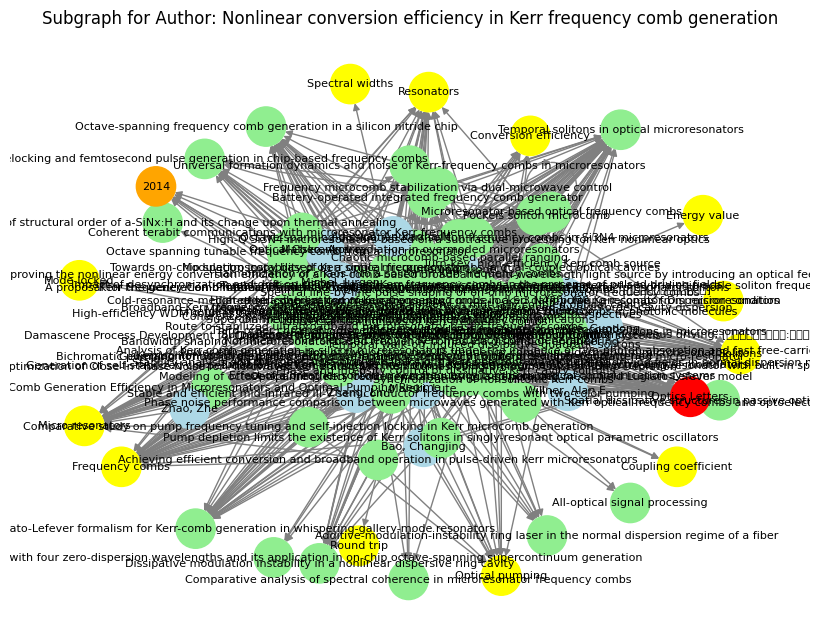

In [44]:
paper_title = "Nonlinear conversion efficiency in Kerr frequency comb generation"

def plot_subgraph(G, paper_title):
    if paper_title not in G:
        print(f"Paper '{paper_title}' not found in graph.")
        return
    
    # 获取该论文的所有相关节点
    related_nodes = set(G.neighbors(paper_title)).union(set(G.predecessors(paper_title)))
    related_nodes.add(paper_title)  # 包含自身
    
    # 创建子图
    subgraph = G.subgraph(related_nodes)

    
    # 颜色映射
    color_map = {"author": "lightblue", "paper": "lightgreen", "keyword": "yellow", "year": "orange", "source": "red"}
    node_colors = [color_map.get(G.nodes[node].get("type", ""), "gray") for node in subgraph.nodes()]
    
    # 绘制
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.5)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=800, font_size=8)
    plt.title(f"Subgraph for Author: {paper_title}")
    plt.show()

# 指定论文名称并绘制子图
plot_subgraph(G, paper_title)

In [7]:
folder_path = "E:ofc\paper json"

nontitle = []

for filename in os.listdir(folder_path):
    name, _ = os.path.splitext(filename)
    norm_name = normalize_title(name)
    
    if norm_name in paper_titles:
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as ref_file:
            references = json.load(ref_file)

        for ref in references:
            if 'Title' in ref and ref['Title']:
                ref_title = ref['Title'].strip()
                norm_ref_title = normalize_title(ref_title)
                volume = ref.get("Volume", "")
                issue = ref.get("Issue", "")
                start_page = ref.get("Starting Page", "")
                end_page = ref.get("Ending Page", "")
                
                volume_issue = []
                if volume:
                    volume_issue.append(f"Vol. {volume}")
                if issue:
                    volume_issue.append(f"No. {issue}")
                vi_str = ", ".join(volume_issue) if volume_issue else ""
                
                pages = []
                if start_page or end_page:
                    if start_page and end_page:
                        pages.append(f"pp. {start_page}-{end_page}")
                    elif start_page:
                        pages.append(f"p. {start_page}")
                page_str = ", ".join(pages) if pages else ""
                
                publication_info = ", ".join(filter(None, [vi_str, page_str]))
    
                if norm_ref_title not in reference_titles and norm_ref_title not in paper_titles:
                    reference_titles[norm_ref_title] = ref_title
                    all_papers[norm_ref_title] = ref
    
                    G.add_node(ref_title, type="paper", is_main=False, details = {
                        "Source": ref.get("Source", ""),
                        "Publication Info": publication_info,
                        "Abstract": ref.get("Abstract", ""),
                    })
    
                main_title = paper_titles[norm_name]
                reference_title = reference_titles.get(norm_ref_title, paper_titles.get(norm_ref_title, ref_title))
    
                G.add_edge(main_title, reference_title, relation="cites")
            else:
                nontitle.append(filename)

print(nontitle)

[]


In [9]:
isolated_nodes = [node for node, degree in G.degree() if degree == 0]

print(f"孤立节点数量: {len(isolated_nodes)}")
print("孤立节点列表:")
for node in isolated_nodes:
    print(f" - 节点名称: {node}, 类型: {G.nodes[node].get('type', 'Unknown')}")

孤立节点数量: 0
孤立节点列表:


In [10]:
# 初始化计数器
node_counts = {
    "author": 0,
    "keyword": 0,
    "year": 0,
    "source": 0,
    "unknown": 0,
    "paper_main": 0,
    "paper_non_main": 0
}

# 遍历图中的所有节点并统计
for node in G.nodes:
    node_type = G.nodes[node].get("type", "Unknown")
    if node_type == "author":
        node_counts["author"] += 1
    elif node_type == "keyword":
        node_counts["keyword"] += 1
    elif node_type == "year":
        node_counts["year"] += 1
    elif node_type == "source":
        node_counts["source"] += 1
    elif node_type == "Unknown":
        node_counts["unknown"] += 1
    elif node_type == "paper":
        is_main = G.nodes[node].get("is_main", False)
        if is_main:
            node_counts["paper_main"] += 1
        else:
            node_counts["paper_non_main"] += 1

# 打印统计结果
print("节点类型统计结果:")
for key, value in node_counts.items():
    print(f" - {key.capitalize()}: {value}")

节点类型统计结果:
 - Author: 2886
 - Keyword: 5787
 - Year: 25
 - Source: 239
 - Unknown: 0
 - Paper_main: 1270
 - Paper_non_main: 11999


In [12]:
def print_nodes_by_type(G, target_type):
    # 筛选出指定类型的节点
    list = []
    nodes_of_target_type = [
        (node, G.nodes[node]) for node in G.nodes if G.nodes[node].get("type") == target_type
    ]
    
    for node, attributes in nodes_of_target_type:
        list.append(node)

    return list

# 示例调用
keyword_list = print_nodes_by_type(G, "keyword")  # 打印所有 author 类型的节点

In [13]:
from Levenshtein import ratio
from itertools import combinations

threshold = 0.95
similar_keywords = []

for kw1, kw2 in combinations(keyword_list, 2):
    sim = ratio(kw1.lower(), kw2.lower())
    if sim >= threshold:
        similar_keywords.append((kw1, kw2, sim))

print(len(similar_keywords))
      
for kw1, kw2, sim in similar_keywords:
    print(f"{kw1} ↔ {kw2}, Levenshtein 相似度: {sim:.2f}")

977
Resonators ↔ resonators, Levenshtein 相似度: 1.00
Solitons ↔ solitons, Levenshtein 相似度: 1.00
Frequency combs ↔ frequency comb, Levenshtein 相似度: 0.97
Frequency combs ↔ Frequency comb, Levenshtein 相似度: 0.97
Frequency combs ↔ frequency combs, Levenshtein 相似度: 1.00
Frequency combs ↔ Frequency Comb, Levenshtein 相似度: 0.97
Micro resonators ↔ Microresonators, Levenshtein 相似度: 0.97
Micro resonators ↔ microresonators, Levenshtein 相似度: 0.97
Micro resonators ↔ Micro resonator, Levenshtein 相似度: 0.97
Conversion efficiency ↔ conversion efficiency, Levenshtein 相似度: 1.00
Aluminum nitride ↔ aluminum nitride, Levenshtein 相似度: 1.00
Dispersions ↔ dispersion, Levenshtein 相似度: 0.95
Dispersions ↔ Dispersion, Levenshtein 相似度: 0.95
Optical resonators ↔ optical resonators, Levenshtein 相似度: 1.00
Optical resonators ↔ Optical Resonators, Levenshtein 相似度: 1.00
Optical resonators ↔ Optical resonator, Levenshtein 相似度: 0.97
Optical resonators ↔ optical resonator, Levenshtein 相似度: 0.97
Microring resonator ↔ micro-ring 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

vectorizer = TfidfVectorizer().fit_transform(keyword_list)
similarity_matrix = cosine_similarity(vectorizer)

similarity_threshold = 0.95
similar_keywords = []

for i in range(len(keyword_list)):
    for j in range(i + 1, len(keyword_list)):
        sim = similarity_matrix[i, j]
        if sim >= similarity_threshold:
            similar_keywords.append((keyword_list[i], keyword_list[j], sim))

print(len(similar_keywords))

# 打印高相似度的关键词
for kw1, kw2, sim in similar_keywords:
    print(f"{kw1} ↔ {kw2}, 余弦相似度: {sim:.2f}")

647
Resonators ↔ resonators, 余弦相似度: 1.00
Solitons ↔ solitons, 余弦相似度: 1.00
Frequency combs ↔ frequency combs, 余弦相似度: 1.00
Conversion efficiency ↔ conversion efficiency, 余弦相似度: 1.00
Aluminum nitride ↔ aluminum nitride, 余弦相似度: 1.00
Optical resonators ↔ optical resonators, 余弦相似度: 1.00
Optical resonators ↔ Optical Resonators, 余弦相似度: 1.00
Pumping (laser) ↔ Laser pumping, 余弦相似度: 1.00
Microring resonator ↔ microring resonator, 余弦相似度: 1.00
silicon ↔ Silicon, 余弦相似度: 1.00
infrared radiation ↔ Infrared radiation, 余弦相似度: 1.00
Article ↔ article, 余弦相似度: 1.00
diode laser ↔ Diode-laser, 余弦相似度: 1.00
frequency modulation ↔ Frequency modulation, 余弦相似度: 1.00
infrared spectroscopy ↔ Infrared spectroscopy, 余弦相似度: 1.00
microtechnology ↔ Microtechnology, 余弦相似度: 1.00
Four-wave mixing ↔ Four-wave-mixing, 余弦相似度: 1.00
Four-wave mixing ↔ Four wave mixing, 余弦相似度: 1.00
Four-wave mixing ↔ four-wave mixing, 余弦相似度: 1.00
Four-wave mixing ↔ four-wave-mixing, 余弦相似度: 1.00
Four-wave mixing ↔ Four Wave Mixing, 余弦相似度: 1.00
Ker

In [15]:
keywords_all = [node for node, data in G.nodes(data=True) if data.get("type") == "keyword"]

# 构建一个新图 H 用于相似关键词连接
H = nx.Graph()
H.add_nodes_from(keywords_all)

# 使用 Levenshtein 相似度计算
threshold = 0.95
for kw1, kw2 in combinations(keywords_all, 2):
    sim = ratio(kw1.lower(), kw2.lower())
    if sim >= threshold:
        H.add_edge(kw1, kw2)

# 获取相似关键词组
similar_groups = [component for component in nx.connected_components(H) if len(component) > 1]

# 复制原图用于合并
K = G.copy()

# 合并相似节点
for group in similar_groups:
    group = list(group)
    representative = None

    for node in group:
        if node.istitle():
            representative = node
            break
            
    if representative is None:
        for node in group:
            if node.isupper():
                representative = node
                break
                
    if representative is None:
        representative = group[0].title()

    print(f"{group} choose node: {representative}")

    if representative not in K.nodes:
        K.add_node(representative, type="keyword")

    neighbors_to_transfer = set()
    for node in group:
        if node != representative and node in K:
            neighbors_to_transfer.update(K.predecessors(node))

    # 将所有邻居连接到代表节点
    for neighbor in neighbors_to_transfer:
        if neighbor != representative and not K.has_edge(neighbor, representative):
            K.add_edge(neighbor, representative)

    # 删除旧的冗余节点
    for node in group:
        if node != representative and node in K:
            K.remove_node(node)


['Resonators', 'resonators'] choose node: Resonators
['solitons', 'Solitons'] choose node: Solitons
['Frequency combs', 'Frequency Comb', 'frequency comb', 'Frequency comb', 'frequency combs'] choose node: Frequency Comb
['Micro resonator', 'microresonator', 'MICRORESONATOR', 'Microresonators', 'Micro resonators', 'Microresonator', 'Micro-resonator', 'micro-resonator', 'microresonators'] choose node: Microresonators
['conversion efficiency', 'Conversion efficiency'] choose node: Conversion Efficiency
['Aluminum nitride', 'aluminum nitride'] choose node: Aluminum Nitride
['Dispersions', 'dispersion', 'Dispersion'] choose node: Dispersions
['Optical Resonators', 'optical resonator', 'Optical resonators', 'Optical resonator', 'optical resonators'] choose node: Optical Resonators
['Microring resonator', 'micro-ring resonators', 'microring resonator', 'micro-ring resonator', 'microring resonators', 'Micro-ring resonator'] choose node: Microring Resonator
['Nonlinear optical materials', 'Non

In [18]:
# 初始化计数器
node_counts = {
    "author": 0,
    "keyword": 0,
    "year": 0,
    "source": 0,
    "unknown": 0,
    "paper_main": 0,
    "paper_non_main": 0
}

# 遍历图中的所有节点并统计
for node in K.nodes:
    node_type = K.nodes[node].get("type", "Unknown")
    if node_type == "author":
        node_counts["author"] += 1
    elif node_type == "keyword":
        node_counts["keyword"] += 1
    elif node_type == "year":
        node_counts["year"] += 1
    elif node_type == "source":
        node_counts["source"] += 1
    elif node_type == "Unknown":
        node_counts["unknown"] += 1
    elif node_type == "paper":
        is_main = K.nodes[node].get("is_main", False)
        if is_main:
            node_counts["paper_main"] += 1
        else:
            node_counts["paper_non_main"] += 1

# 打印统计结果
print("节点类型统计结果:")
for key, value in node_counts.items():
    print(f" - {key.capitalize()}: {value}")

节点类型统计结果:
 - Author: 2886
 - Keyword: 1153
 - Year: 25
 - Source: 239
 - Unknown: 0
 - Paper_main: 1270
 - Paper_non_main: 11999


In [17]:
keywords_to_remove = []
for node in K.nodes:
    if K.nodes[node].get("type") == "keyword":  
        if K.degree(node) <= 2:  
            keywords_to_remove.append(node)


for kw in keywords_to_remove:
    K.remove_node(kw)

print(f"Removed {len(keywords_to_remove)} keyword nodes that were connected to only one title.")

Removed 3919 keyword nodes that were connected to only one title.


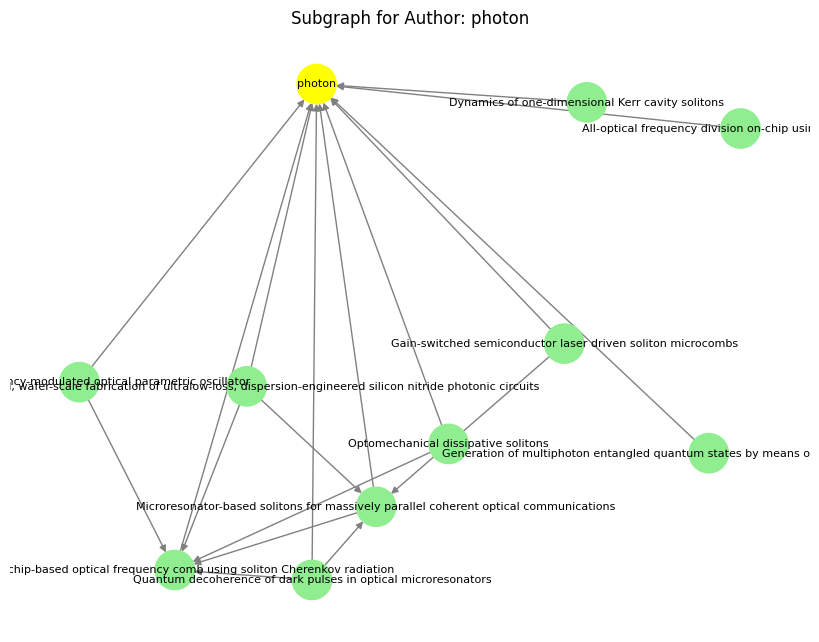

In [19]:
paper_title = "photon"

def plot_subgraph(G, paper_title):
    if paper_title not in G:
        print(f"Paper '{paper_title}' not found in graph.")
        return
    
    # 获取该论文的所有相关节点
    related_nodes = set(G.neighbors(paper_title)).union(set(G.predecessors(paper_title)))
    related_nodes.add(paper_title)  # 包含自身
    
    # 创建子图
    subgraph = G.subgraph(related_nodes)

    
    # 颜色映射
    color_map = {"author": "lightblue", "paper": "lightgreen", "keyword": "yellow", "year": "orange", "source": "red"}
    node_colors = [color_map.get(G.nodes[node].get("type", ""), "gray") for node in subgraph.nodes()]
    
    # 绘制
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.5)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=800, font_size=8)
    plt.title(f"Subgraph for Author: {paper_title}")
    plt.show()

# 指定论文名称并绘制子图
plot_subgraph(K, paper_title)

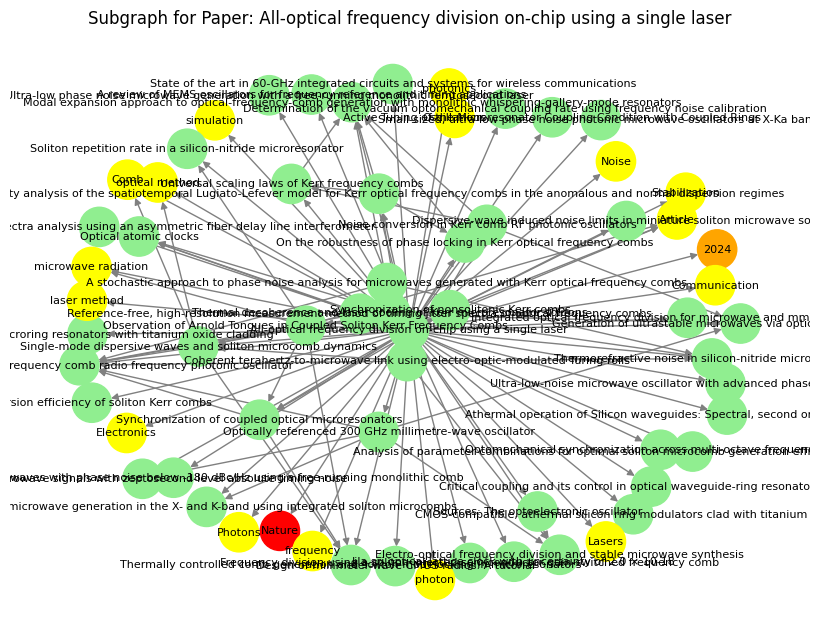

In [20]:
paper_title = "All-optical frequency division on-chip using a single laser"

def plot_subgraph(G, paper_title):
    if paper_title not in G:
        print(f"Paper '{paper_title}' not found in graph.")
        return
    
    # 获取该论文的所有相关节点
    related_nodes = set(G.neighbors(paper_title))
    related_nodes.add(paper_title)  # 包含自身
    
    # 创建子图
    subgraph = G.subgraph(related_nodes)

    
    # 颜色映射
    color_map = {"author": "lightblue", "paper": "lightgreen", "keyword": "yellow", "year": "orange", "source": "red"}
    node_colors = [color_map.get(G.nodes[node].get("type", ""), "gray") for node in subgraph.nodes()]
    
    # 绘制
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.5)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=800, font_size=8)
    plt.title(f"Subgraph for Paper: {paper_title}")
    plt.show()

# 指定论文名称并绘制子图
plot_subgraph(K, paper_title)

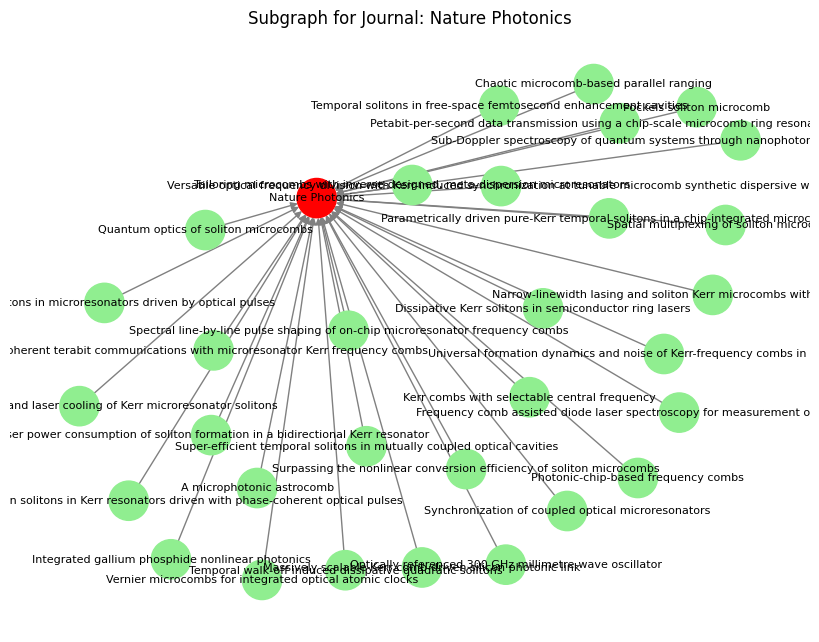

In [45]:
paper_title = "Nature Photonics"

def plot_subgraph_with_types(G, paper_title, target_types=None):
    if paper_title not in G:
        print(f"Paper '{paper_title}' not found in graph.")
        return
    
    # 获取该论文的所有相关节点
    related_nodes = set(G.neighbors(paper_title)).union(set(G.predecessors(paper_title)))
    related_nodes.add(paper_title)  # 包含自身
    
    # 如果指定了目标类型，筛选出符合条件的节点
    if target_types:
        filtered_nodes = {
            node for node in related_nodes
            if G.nodes[node].get("type") in target_types or node == paper_title
        }
    else:
        filtered_nodes = related_nodes
    
    # 创建子图
    subgraph = G.subgraph(filtered_nodes)

    
    # 颜色映射
    color_map = {"author": "lightblue", "paper": "lightgreen", "keyword": "yellow", "year": "orange", "source": "red"}
    node_colors = [color_map.get(G.nodes[node].get("type", ""), "gray") for node in subgraph.nodes()]
    
    # 绘制
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.5)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=800, font_size=8)
    plt.title(f"Subgraph for Journal: {paper_title}")
    plt.show()

# 指定论文名称并绘制子图，只获取特定类型的节点
plot_subgraph_with_types(G, paper_title, target_types=["paper"])  # 只获取作者和关键词节点

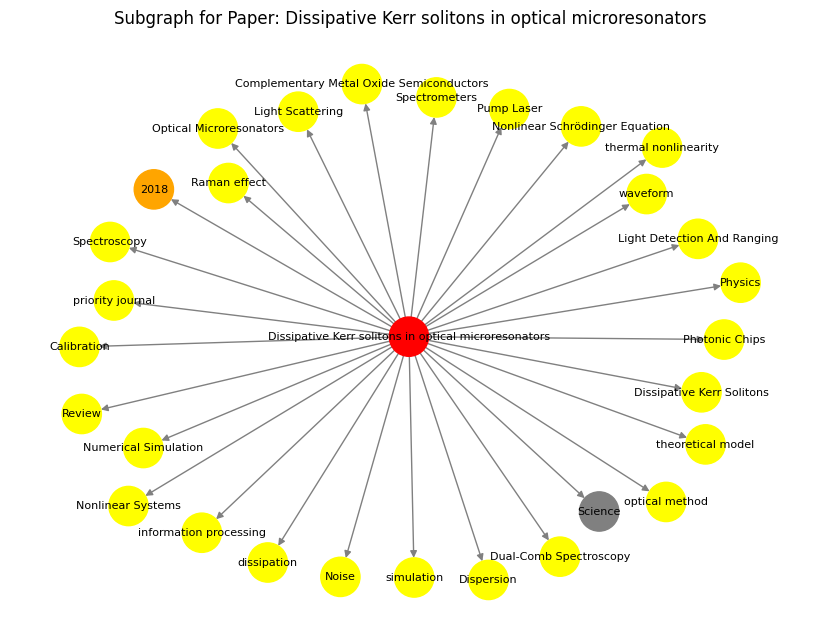

In [43]:
paper_title = "Dissipative Kerr solitons in optical microresonators"

def plot_subgraph_with_direction(G, paper_title, target_types=None):
    if paper_title not in G:
        print(f"Paper '{paper_title}' not found in graph.")
        return
    
    # 获取该论文的所有相关节点
    related_nodes = set(G.neighbors(paper_title))
    related_nodes.add(paper_title)  # 包含自身
    
    # 如果指定了目标类型，筛选出符合条件的节点
    if target_types:
        filtered_nodes = {
            node for node in related_nodes
            if G.nodes[node].get("type") in target_types or node == paper_title
        }
    else:
        filtered_nodes = related_nodes
    
    # 创建子图
    subgraph = G.subgraph(filtered_nodes)

    
    # 颜色映射
    color_map = {"author": "lightblue", "paper": "lightgreen", "keyword": "yellow", "year": "orange"}
    node_colors = [
    "red" if G.nodes[node].get("is_main", False) else color_map.get(G.nodes[node].get("type", ""), "gray")
    for node in subgraph.nodes()
]
    
    # 绘制
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.5)  # 布局
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color="gray",
            node_size=800, font_size=8, arrows=True)  # arrows=True 显示箭头

    # 添加边的标签
    edge_labels = {(u, v): d.get("relation", "") for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Subgraph for Paper: {paper_title}")
    plt.show()

# 指定论文名称并绘制子图，只获取特定类型的节点
plot_subgraph_with_direction(K, paper_title, target_types=["author", "keyword", "year", "source", "paper"])  # 只获取论文和引用关系

In [21]:
from networkx.readwrite import json_graph

data = json_graph.node_link_data(G)
with open("graph_data.json", "w") as f:
    json.dump(data, f)

In [22]:
import csv

# -------------------- NODES CSV --------------------
with open("nodes.csv", "w", newline="", encoding="utf-8") as node_file:
    writer = csv.writer(node_file)
    # 假设每个节点都有 type 属性
    writer.writerow(["id:ID", "type", ":LABEL"])
    for node, data in G.nodes(data=True):
        node_type = data.get("type", "Keyword")  # 默认类型
        writer.writerow([node, node_type, node_type.capitalize()])

# -------------------- EDGES CSV --------------------
with open("edges.csv", "w", newline="", encoding="utf-8") as edge_file:
    writer = csv.writer(edge_file)
    # 你可以自定义关系类型，比如 "RELATED_TO" 或 "CONNECTED"
    writer.writerow([":START_ID", ":END_ID", ":TYPE"])
    for source, target in G.edges():
        writer.writerow([source, target, "RELATED_TO"])


In [30]:
from py2neo import Graph, Node, Relationship

# 连接到 Neo4j 数据库
graph = Graph("neo4j+s://a36f6471.databases.neo4j.io", auth=("neo4j", "E7QyiOiiDAi0SjQY7eXvUyjNPNzEHa4sYsMdlTqc1gI"))

# 1. 创建唯一约束，避免重复节点
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (p:Paper) REQUIRE p.title IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (a:Author) REQUIRE a.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (k:Keyword) REQUIRE k.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (y:Year) REQUIRE y.year IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (s:Source) REQUIRE s.name IS UNIQUE")  # 新增 Source 约束

# 2. 批量导入节点
tx = graph.begin()

for node, attr in K.nodes(data=True):
    node_type = attr.get("type")

    if node_type == "paper":
        paper = Node("Paper", title=node, is_main=attr.get("is_main", False), **attr.get("details", {}))
        tx.merge(paper, "Paper", "title")
    
    elif node_type == "author":
        author = Node("Author", name=node, author_ids=attr.get("author_ids", ""))
        tx.merge(author, "Author", "name")
    
    elif node_type == "keyword":
        keyword = Node("Keyword", name=node)
        tx.merge(keyword, "Keyword", "name")
    
    elif node_type == "year":
        year = Node("Year", year=node)
        tx.merge(year, "Year", "year")

    elif node_type == "source":  # 期刊/会议
        source = Node("Source", name=node, source_type=attr.get("source_type", ""))
        tx.merge(source, "Source", "name")

# 提交所有节点
graph.commit(tx)

# 3. 批量导入关系
tx = graph.begin()

for source, target, attr in K.edges(data=True):
    # 先匹配源节点
    source_node = graph.nodes.match("Author", name=source).first() or \
                  graph.nodes.match("Paper", title=source).first() or \
                  graph.nodes.match("Keyword", name=source).first() or \
                  graph.nodes.match("Year", year=source).first() or \
                  graph.nodes.match("Source", name=source).first()  # 新增匹配 Source
    
    # 再匹配目标节点
    target_node = graph.nodes.match("Author", name=target).first() or \
                  graph.nodes.match("Paper", title=target).first() or \
                  graph.nodes.match("Keyword", name=target).first() or \
                  graph.nodes.match("Year", year=target).first() or \
                  graph.nodes.match("Source", name=target).first()  # 新增匹配 Source

    if source_node and target_node:
        if source_node.has_label("Author") and target_node.has_label("Paper"):
            rel = Relationship(source_node, "WROTE", target_node)
        elif source_node.has_label("Paper") and target_node.has_label("Year"):
            rel = Relationship(source_node, "PUBLISHED_IN_YEAR", target_node)
        elif source_node.has_label("Paper") and target_node.has_label("Source"):
            rel = Relationship(source_node, "PUBLISHED_IN_SOURCE", target_node)
        elif source_node.has_label("Paper") and target_node.has_label("Keyword"):
            rel = Relationship(source_node, "KEYWORD", target_node)
        elif attr.get("relation") == "cites":
            rel = Relationship(source_node, "CITES", target_node)
        else:
            rel = Relationship(source_node, "RELATED_TO", target_node)
        
        tx.merge(rel)

# 提交所有关系
graph.commit(tx)

print("数据导入完成！")

KeyboardInterrupt: 

In [23]:
from py2neo import Graph, Node, Relationship

# 连接到 Neo4j 数据库
graph = Graph("neo4j+s://a36f6471.databases.neo4j.io", auth=("neo4j", "E7QyiOiiDAi0SjQY7eXvUyjNPNzEHa4sYsMdlTqc1gI"))

# 1. 创建唯一约束，避免重复节点
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (p:Paper) REQUIRE p.title IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (a:Author) REQUIRE a.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (k:Keyword) REQUIRE k.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (y:Year) REQUIRE y.year IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (s:Source) REQUIRE s.name IS UNIQUE")

from collections import defaultdict

# 准备节点数据分组
nodes_by_type = defaultdict(list)

for node_id, attr in K.nodes(data=True):
    node_type = attr.get("type")

    if node_type == "paper":
        nodes_by_type["Paper"].append({
            "title": node_id,
            "is_main": attr.get("is_main", False),
            **attr.get("details", {})
        })
    elif node_type == "author":
        nodes_by_type["Author"].append({
            "name": node_id,
            "author_ids": attr.get("author_ids", "")
        })
    elif node_type == "keyword":
        nodes_by_type["Keyword"].append({"name": node_id})
    elif node_type == "year":
        nodes_by_type["Year"].append({"year": node_id})
    elif node_type == "source":
        nodes_by_type["Source"].append({
            "name": node_id,
            "source_type": attr.get("source_type", "")
        })

# 批量导入每一类节点
for label, data_list in nodes_by_type.items():
    if not data_list:
        continue

    query = f"""
    UNWIND $data AS item
    MERGE (n:{label} {{{list(data_list[0].keys())[0]}: item.{list(data_list[0].keys())[0]}}})
    SET n += item
    """
    graph.run(query, data=data_list)


In [24]:
edges_by_type = defaultdict(list)

for source, target, _ in K.edges(data=True):
    s_type = K.nodes[source].get("type")
    t_type = K.nodes[target].get("type")

    if s_type == "author" and t_type == "paper":
        rel_type = "WROTE"
        s_label, s_key = "Author", "name"
        t_label, t_key = "Paper", "title"
    elif s_type == "paper" and t_type == "year":
        rel_type = "PUBLISHED_IN_YEAR"
        s_label, s_key = "Paper", "title"
        t_label, t_key = "Year", "year"
    elif s_type == "paper" and t_type == "source":
        rel_type = "PUBLISHED_IN_SOURCE"
        s_label, s_key = "Paper", "title"
        t_label, t_key = "Source", "name"
    elif s_type == "paper" and t_type == "keyword":
        rel_type = "KEYWORD"
        s_label, s_key = "Paper", "title"
        t_label, t_key = "Keyword", "name"
    elif s_type == "paper" and t_type == "paper":
        rel_type = "CITES"
        s_label, s_key = "Paper", "title"
        t_label, t_key = "Paper", "title"
    else:
        rel_type = "RELATED_TO"
        s_label, s_key = s_type.capitalize(), "name"
        t_label, t_key = t_type.capitalize(), "name"

    edges_by_type[(rel_type, s_label, s_key, t_label, t_key)].append({
        "source_id": source,
        "target_id": target
    })

# 批量导入每一类关系
for (rel_type, s_label, s_key, t_label, t_key), edge_list in edges_by_type.items():
    query = f"""
    UNWIND $data AS row
    MATCH (a:{s_label} {{{s_key}: row.source_id}})
    MATCH (b:{t_label} {{{t_key}: row.target_id}})
    MERGE (a)-[r:{rel_type}]->(b)
    """
    graph.run(query, data=edge_list)

In [38]:
from collections import defaultdict

# 用于批量分组的容器
edges_by_type = defaultdict(list)

for source, target, attr in K.edges(data=True):
    
    source_type = K.nodes[source].get("type")
    target_type = K.nodes[target].get("type")

    if source_type == "author" and target_type == "paper":
        rel_type = "WROTE"
    elif source_type == "paper" and target_type == "year":
        rel_type = "PUBLISHED_IN_YEAR"
    elif source_type == "paper" and target_type == "source":
        rel_type = "PUBLISHED_IN_SOURCE"
    elif source_type == "paper" and target_type == "keyword":
        rel_type = "KEYWORD"
    elif source_type == "paper" and target_type == "paper":
        rel_type = "CITES"
    else:
        rel_type = "RELATED_TO"

    edges_by_type[rel_type].append({"source": source, "target": target})


In [41]:
len(edges_by_type["CITES"])

0

In [82]:
query = """
MATCH (p1:Paper)-[:CITES]->(p2:Paper)
RETURN p1.title AS citing_paper, p2.title AS cited_paper
LIMIT 5
"""
result = graph.run(query).data()
for record in result:
    print(f"论文 '{record['citing_paper']}' 引用了 '{record['cited_paper']}'")

论文 'Nonlinear conversion efficiency in Kerr frequency comb generation' 引用了 'Mode-locked Kerr frequency combs'
论文 'Nonlinear conversion efficiency in Kerr frequency comb generation' 引用了 'Coherent terabit communications with microresonator Kerr frequency combs'
论文 'Nonlinear conversion efficiency in Kerr frequency comb generation' 引用了 'Microresonator-based optical frequency combs'
论文 'Nonlinear conversion efficiency in Kerr frequency comb generation' 引用了 'Universal scaling laws of Kerr frequency combs'
论文 'Nonlinear conversion efficiency in Kerr frequency comb generation' 引用了 'Octave spanning tunable frequency comb from a microresonator'


In [ ]:
from langchain.prompts import PromptTemplate

cypher_generation_template = """
任务：为Neo4j图数据库生成Cypher查询。``说明：仅使用提供的模式中的关系类型和属性，不要使用任何未提供的其他关系类型或属性。
模式：{schema}
注意：不要回答任何可能要求你构建除Cypher语句之外的任何文本的问题。
确保查询中的关系方向是正确的，确保正确地为实体和关系设置别名。
不要运行会向数据库添加或删除内容的任何查询。
问题是：{question}``"""   
cypher_generation_prompt = PromptTemplate(input_variables=["schema", "question"], template=cypher_generation_template)
qa_generation_template = """你是一个助手，根据Neo4j Cypher查询的结果生成人类可读的响应。查询结果部分包含基于用户自然语言问题生成的Cypher查询的结果。
查询结果：{context}
问题：{question}
如果提供的信息为空，请说你不知道答案。
如果信息不为空，您必须使用结果提供答案。"""   
qa_generation_prompt = PromptTemplate(`    `input_variables=["context", "question"], template=qa_generation_template)

from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI

graph = Neo4jGraph(url="bolt://localhost:7687", username="******", password="******")
graph.refresh_schema()
hospital_cypher_chain = GraphCypherQAChain.from_llm(cypher_llm=ChatOpenAI(model='gpt-4o'), qa_llm=ChatOpenAI(model='gpt-4o'), graph=graph, verbose=True, 
                                                    qa_prompt=qa_generation_prompt, cypher_prompt=cypher_generation_prompt, validate_cypher=True, top_k=100)
response = hospital_cypher_chain.invoke("张三订购了哪些产品?总金额是多少")
print(response['result'])
